In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from tqdm import tqdm
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder


In [2]:
data_path=r"D:\college\speech recognition\asiignments\ass1\data\archive"

In [4]:
def load_audio_files(data_path, labels):
    X, y = [], []
    for label in labels:
        files = os.listdir(os.path.join(data_path, label))
        for file in tqdm(files):
            try:
                audio_path = os.path.join(data_path, label, file)
                audio, sr = librosa.load(audio_path, sr=16000)

                # Extract and resize MFCCs to 64x64
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=64)  
                mfccs = np.resize(mfccs, (64, 64))  

                # Normalize
                mfccs = (mfccs - np.min(mfccs)) / (np.max(mfccs) - np.min(mfccs))

                X.append(mfccs)
                y.append(label)
            except Exception as e:
                print(f"Error loading {file}: {e}")

    return np.array(X), np.array(y)

labels = os.listdir(data_path)
X, y = load_audio_files(data_path, labels)


 57%|█████▋    | 4/7 [00:00<00:00,  5.64it/s]C:\Users\husse\AppData\Local\Temp\ipykernel_8008\1994546401.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(audio_path, sr=16000)
C:\Users\husse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loading README.md: 


100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


In [5]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Reshape to fit CNN input
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]


In [6]:
def add_noise(data, noise_factor=0.005):
    return data + noise_factor * np.random.normal(size=data.shape)

# Apply augmentation to training data 
X_train_noisy = add_noise(X_train)
X_train = np.concatenate([X_train, X_train_noisy])
y_train = np.concatenate([y_train, y_train]) 


In [7]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(labels), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\husse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,199,967 (8.39 MB)

 Trainable params: 2,199,007 (8.39 MB)

 Non-trainable params: 960 (3.75 KB)

In [9]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)


In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/15
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 418s 128ms/step - accuracy: 0.1922 - loss: 3.0349 - val_accuracy: 0.1216 - val_loss: 4.0932 - learning_rate: 0.0010
Epoch 2/15
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 414s 128ms/step - accuracy: 0.5377 - loss: 1.5731 - val_accuracy: 0.4638 - val_loss: 2.2574 - learning_rate: 0.0010
Epoch 3/15
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 412s 127ms/step - accuracy: 0.6337 - loss: 1.2380 - val_accuracy: 0.0417 - val_loss: 246.3181 - learning_rate: 0.0010
Epoch 4/15
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 407s 126ms/step - accuracy: 0.6724 - loss: 1.1085 - val_accuracy: 0.5167 - val_loss: 3.4400 - learning_rate: 0.0010
Epoch 5/15
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 414s 128ms/step - accuracy: 0.6869 - loss: 1.0453 - val_accuracy: 0.7614 - val_loss: 0.7898 - learning_rate: 0.0010
Epoch 6/15
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 419s 129ms/step - accuracy: 0.7297 - loss: 0.9022 - val_accuracy: 0.7668 - val_loss: 0.8846 - learning_rate: 0.0010
Epoch 7/15
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 415s 128

In [11]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.2f}")


405/405 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8755 - loss: 0.4797
Validation Accuracy: 0.88


405/405 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step
Classification Report:
                    precision    recall  f1-score   support

_background_noise_       0.09      1.00      0.17         1
               bed       0.90      0.82      0.86       343
              bird       0.93      0.86      0.89       346
               cat       0.94      0.86      0.90       347
               dog       0.89      0.82      0.85       349
              down       0.87      0.86      0.87       472
             eight       0.97      0.90      0.93       470
              five       0.85      0.83      0.84       471
              four       0.89      0.90      0.90       475
                go       0.75      0.78      0.76       474
             happy       0.98      0.94      0.96       348
             house       0.91      0.97      0.94       350
              left       0.85      0.89      0.87       471
            marvin       0.85      0.92      0.88       349
              nine       0.90     

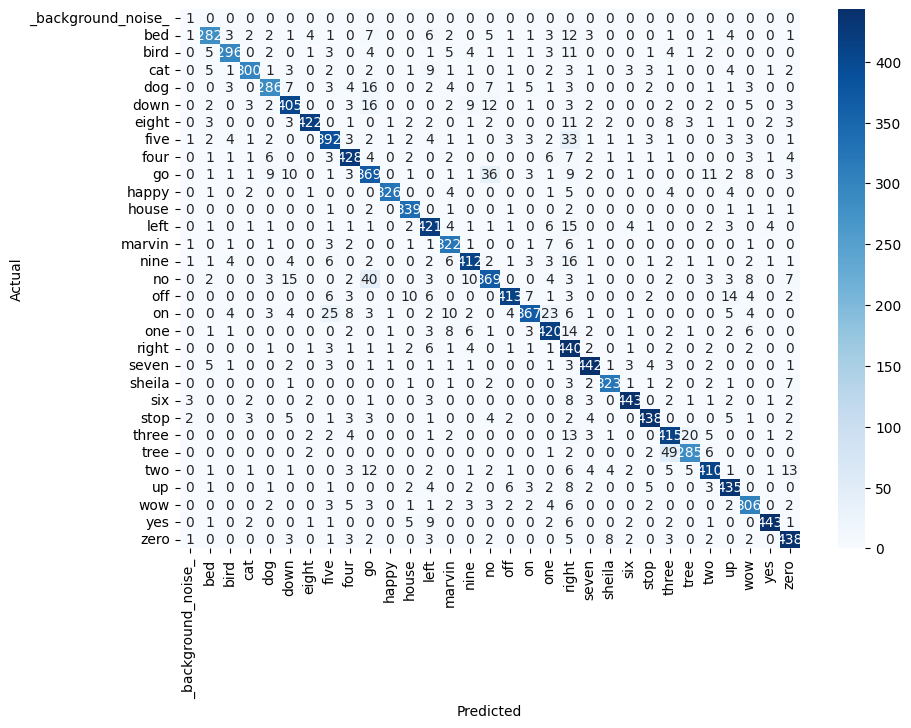

In [12]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=le.classes_))

conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


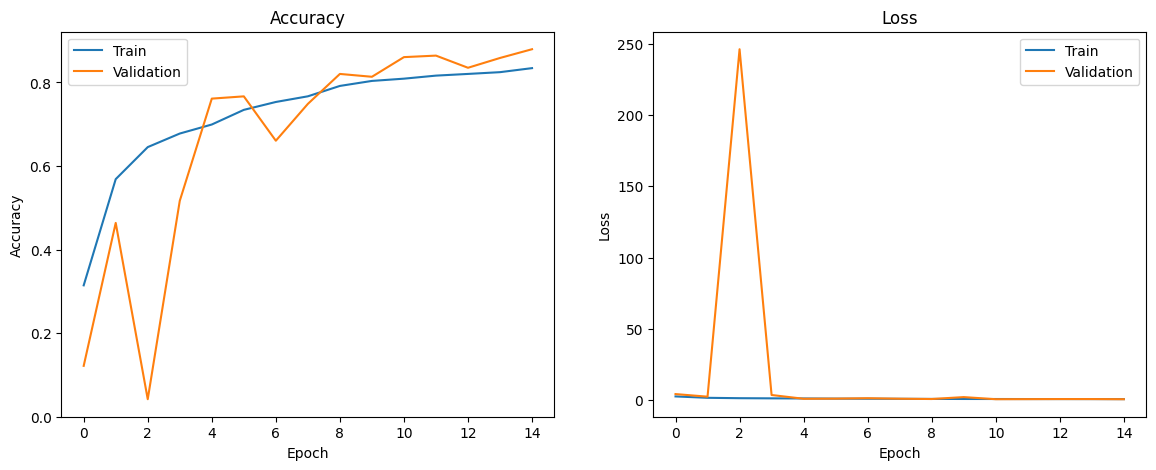

In [13]:
# Accuracy and Loss Curves
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()
